In [36]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Some functions:**

In [37]:
def compare_attitudes(gaia, Solver, my_times):
    fig = plt.figure()
    colors = ['red', 'orange', 'blue', 'green']
    labels_gaia = ["w", "x", "y", "z"]
    labels_solver = ["w_solv", "x_solv", "y_solv", "z_solv"]
    gaia_attitudes = [gaia.s_w(my_times), gaia.s_x(my_times), 
                      gaia.s_y(my_times), gaia.s_z(my_times)]
    solver_attitudes = []
    for i in range(4):
        plt.plot(my_times,gaia_attitudes[i], ':', color=colors[i], label=labels_gaia[i])
        plt.plot(my_times,Solver.attitude_splines[i](my_times), '--', color=colors[i], label=labels_solver[i])
    plt.xlabel("my_times [%s]"%len(my_times))
    plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
    plt.title('Attitudes in time intervals')
    plt.show()

# **Initializing objects:**

In [38]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0  #1/24/60   #  TODO make code work also for t_init != 0
t_end = t_init + 1/24 # 365*5
my_dt = 1/24/20 # [days]

spline_degree = 3  # actually it is the spline degree
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=100, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


len(real_sources):  100


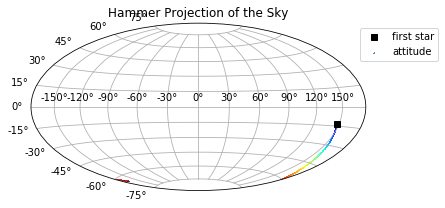

In [39]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []
#print('my_times: ', my_times)
print('len(real_sources): ', len(real_sources))
for i, s in enumerate(real_sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        #plt.plot( alpha, delta,',')
        pass
plt.scatter(alphas, deltas, c=my_times, marker='+', s=(72./fig.dpi)**2, cmap='jet', alpha=0.8,
               label='attitude', lw=2)

plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

In [40]:
# test if source and calc source are equal (as they should be)
np.testing.assert_array_almost_equal(np.array(real_sources[0].get_parameters()[0:5]), calc_sources[0].s_params)

In [160]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], spline_degree=spline_degree,
             attitude_regularisation_factor=0)

# **About splines:**

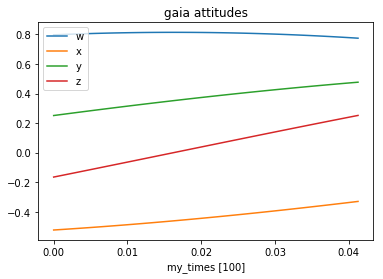

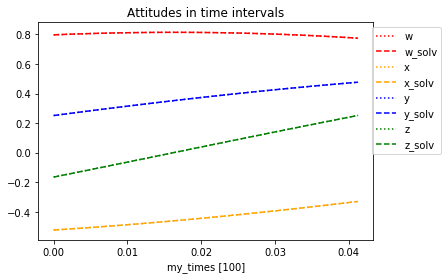

In [161]:
plt.plot(my_times,gaia.s_w(my_times),label="w")
plt.plot(my_times,gaia.s_x(my_times),label="x")
plt.plot(my_times,gaia.s_y(my_times),label="y")
plt.plot(my_times,gaia.s_z(my_times),label="z")
plt.xlabel("my_times [%s]"%len(my_times)), plt.title('gaia attitudes')
plt.legend()
plt.show()
compare_attitudes(gaia, Solver, my_times)

In [162]:
gaia.s_w.get_knots()

array([0.        , 0.00416667, 0.00625   , 0.00833333, 0.01041667,
       0.0125    , 0.01458333, 0.01666667, 0.01875   , 0.02083333,
       0.02291667, 0.025     , 0.02708333, 0.02916667, 0.03125   ,
       0.03333333, 0.03541667, 0.0375    , 0.04166667])

## test: Play with splines:


### Test compute_coeff_basis_sum:

In [163]:
# two quick tests:
np.testing.assert_array_almost_equal(t_init, my_times[0])  # could fail if we change how we define my_times
np.testing.assert_array_almost_equal(t_init, np.array(gaia.storage)[:, 0][0])  # should not fail

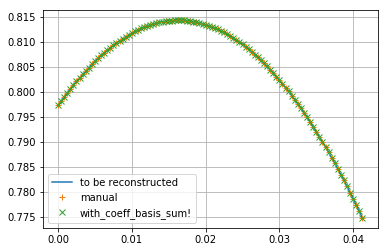

(None, <matplotlib.legend.Legend at 0x7f2fbda1e240>, None)

In [164]:
to_fit = gaia.s_w
plt.plot(my_times, to_fit(my_times), label='to be reconstructed')
B = Solver.att_bases
a = Solver.att_coeffs[0]

def Splines(t, a, B, my_times):
    time_index = list(my_times).index(t)
    left_index = get_left_index(Solver.att_knots, t, M=Solver.M)
    S = 0
    for i in range(len(a)):
        S += a[i]*B[i, time_index]
    S2 = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases, left_index, Solver.M, time_index)
    return S, S2

S_evaluated = []
S_bis = []
for t in my_times:
    S, S2 = Splines(t, a, B, my_times)
    S_evaluated.append(S)
    S_bis.append(S2[0])
    

plt.plot(my_times, S_evaluated, '+', label='manual')
plt.plot(my_times, S_bis, 'x', label='with_coeff_basis_sum!')
plt.grid(), plt.legend(), plt.show()
# Solver.iterate(1)

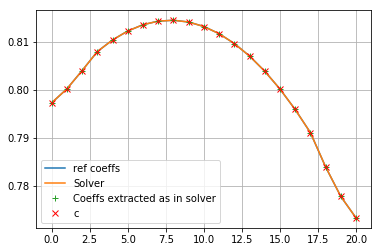

(None, <matplotlib.legend.Legend at 0x7f2fbc6a40b8>, None)

In [165]:
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

# **Tests:**

## Test_0:
Test that the sources are aligned with the attitude

In [166]:
import astropy.units as u

eta,zeta = calculated_field_angles(calc_sources[0], gaia.func_attitude(my_times[0]), gaia, my_times[0])
print(np.array([eta,zeta])*u.rad.to(u.mas))
del u

[-3.43499906e-08 -8.01499780e-08]


OK

## Test_1:
Test the design and normal matrix:  
line 366 in agis.py should be checked:  dR_da_n = dR_da_i(dR_dq, self.att_bases[:, n_index, obs_time_index])  
some times are out of the knots range...

In [167]:
left_index = get_left_index(Solver.att_knots, my_times[0], M=Solver.M)

## Test_2:


21
Is the matrix symmetric?  True


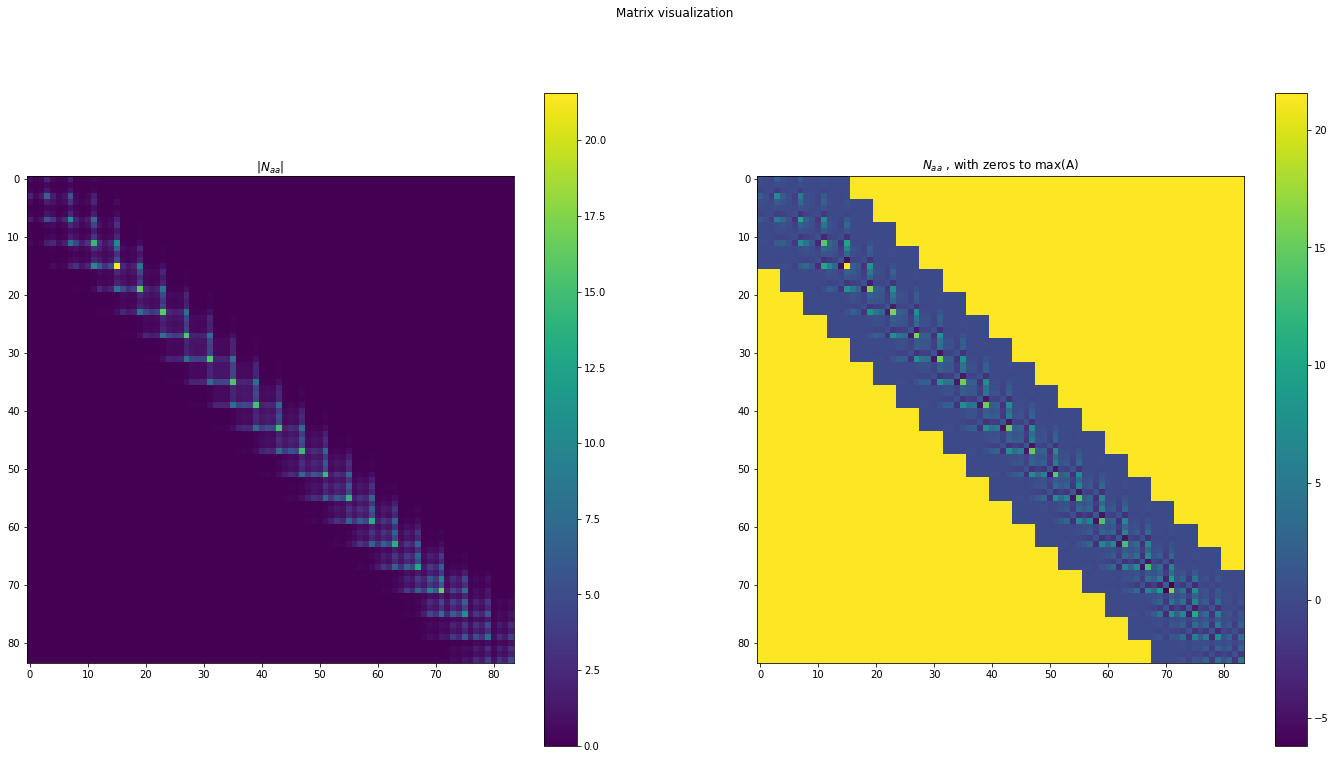

In [168]:
N_aa = Solver.compute_attitude_LHS()

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
plot1 = axs[0].imshow(np.abs(N_aa), vmin=None, vmax=None)
axs[0].set_title("$|N_{aa}|$")

A = N_aa.copy()
threshold = 0
A[np.where(A==threshold)] = A.max()
plot2 = axs[1].imshow(A, vmin=None, vmax=None)
axs[1].set_title("$N_{aa}$ , with zeros to max(A)")

fig.colorbar(plot1, ax=axs[0])
fig.colorbar(plot2, ax=axs[1])
fig.suptitle('Matrix visualization')

print('Is the matrix symmetric? ', helpers.check_symmetry(N_aa))

(Text(0.5, 1.0, 'eigenvalues'),
 Text(0, 0.5, 'log scale (value)'),
 Text(0.5, 0, '#eigval'),
 None)

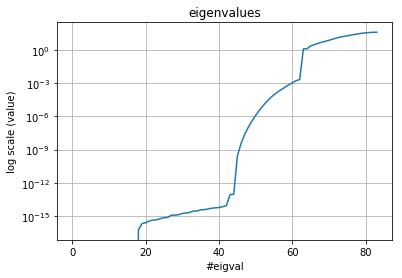

In [169]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals)
plt.yscale('log')
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval'), plt.grid()

## **Test dR_dq = compute_dR_dq(calc_source, Solver.sat, attitude, t_L):** 

In [206]:
coeff_basis_sum, attitude

(array([ 0.79730314, -0.52333902,  0.25138871, -0.16500816]),
 Quaternion(0.7973031372498784 + -0.5233390196383195 i + 0.2513887135443007 j + -0.1650081590650768 k))

**Checking that attitudes returns something similar to coeff_basis_sum:**

In [238]:
my_time_number = 20


t_L = my_times[my_time_number]
time_index = list(my_times).index(t_L)
left_index = get_left_index(Solver.att_knots, t_L, M=Solver.M)

coeff_basis_sum = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases, left_index, Solver.M, time_index)

calc_source = Solver.calc_sources[my_time_number]
attitude = Solver.get_attitude(t_L)
att2 = Quaternion(coeff_basis_sum[0], coeff_basis_sum[1], coeff_basis_sum[2], coeff_basis_sum[3])
dR_dq_1 = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)
dR_dq_2 = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)

np.testing.assert_array_almost_equal(dR_dq_1, dR_dq_2)  # should not fail
print('dR_dq_1:', dR_dq_1)
print('dR_dq_2:', dR_dq_2)

eta, zeta: -1.1102230246251565e-16 -1.8041124150158794e-16
eta, zeta: -1.1102230246251565e-16 -1.8041124150158794e-16
dR_dq_1: [ 0.77078887  0.4477585  -0.63233264  2.60874535]
dR_dq_2: [ 0.77078887  0.4477585  -0.63233264  2.60874535]


**Checking dR_da:**

In [262]:
Solver.att_bases[0, 11]

0.0

In [243]:
m_index = 3

dR_da_m = dR_da_i(dR_dq, Solver.att_bases[m_index, time_index])
dR_da_m

array([[ 0.13879896],
       [ 0.02879352],
       [-0.09132137],
       [ 0.44021405]])

## Extra tests:

# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs = Solver.att_coeffs + c_noise
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

In [170]:
for i in range(0, 3):
    # np.testing.assert_array_equal(Solver.att_bases[i], Solver.att_bases[i+1])
    pass

### Taking a look at the splines:

In [171]:
gaia.s_w.get_knots()

array([0.        , 0.00416667, 0.00625   , 0.00833333, 0.01041667,
       0.0125    , 0.01458333, 0.01666667, 0.01875   , 0.02083333,
       0.02291667, 0.025     , 0.02708333, 0.02916667, 0.03125   ,
       0.03333333, 0.03541667, 0.0375    , 0.04166667])

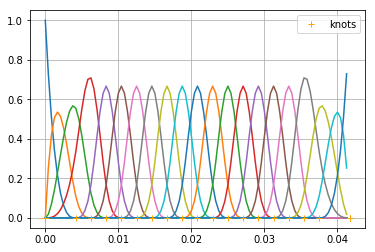

shape Solver.att_bases: (21, 100)
time ranging from:  0.0  to  0.041249999999999995
N= (4, 21)  || k= (25,)  || M= 4


In [172]:
basis = Solver.att_bases
f1 = plt.figure()
for b in basis:
    # plt.plot(range(len(my_times)), b)
    plt.plot(my_times, b)
plt.plot(Solver.att_knots, np.zeros(Solver.att_knots.shape), '+', color='orange', label='knots')
plt.grid(), plt.legend()
plt.show()

print('shape Solver.att_bases:', Solver.att_bases.shape)
print('time ranging from: ', my_times[0], ' to ', my_times[-1])
print('N=',Solver.att_coeffs.shape, ' || k=', Solver.att_knots.shape, ' || M=',Solver.M)

# **Taking a look to intermediate functions:**

**The N_aa[n,m] block:**

In [265]:
# set index and initialize block
m_index, n_index = (12, 14)
Naa_mn = np.zeros((4, 4))

In [266]:
# WARNING: here we take the knots of w since they should be the same for the 4 components
observed_times_m = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots, m_index, Solver.M)
observed_times_n = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots, n_index, Solver.M)

observed_times_mn = np.sort(helpers.get_lists_intersection(observed_times_m, observed_times_n))

print('knot m:', Solver.att_knots[m_index], 'knot m+M:', Solver.att_knots[m_index+Solver.M])
print('observed_times_mn:', observed_times_m)
print('knot n:', Solver.att_knots[n_index], 'knot n+M:', Solver.att_knots[n_index+Solver.M])
print('observed_times_mn:', observed_times_n)

print('\nobserved_times_mn:', observed_times_mn)

knot m: 0.020833333333333332 knot m+M: 0.029166666666666664
observed_times_mn: [0.02125    0.02166667 0.02208333 0.0225     0.02291667 0.02333333
 0.02375    0.02416667 0.02458333 0.025      0.02541667 0.02583333
 0.02625    0.02666667 0.02708333 0.0275     0.02791667 0.02833333
 0.02875   ]
knot n: 0.024999999999999998 knot n+M: 0.03333333333333333
observed_times_mn: [0.02541667 0.02583333 0.02625    0.02666667 0.02708333 0.0275
 0.02791667 0.02833333 0.02875    0.02916667 0.02958333 0.03
 0.03041667 0.03083333 0.03125    0.03166667 0.03208333 0.0325
 0.03291667]

observed_times_mn: [0.02541667 0.02583333 0.02625    0.02666667 0.02708333 0.0275
 0.02791667 0.02833333 0.02875   ]


In [267]:
# compute dDL_da block
dDL_da_mn = np.zeros((4, 4))
for i, t_L in enumerate(observed_times_mn):
    
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots, t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)
    if i<3:
        print('***** iteration #', i ,' *****')
        print('t:',t_L,' // source_index:', source_index, ' // time_index:', obs_time_index, )
        print('time according to time_index:', Solver.all_obs_times[obs_time_index], ' // left_index',left_index)
        print('before_left_index: ',Solver.att_knots[left_index-1], 
              ' // knot left_index:',Solver.att_knots[left_index], 
              ' // knot after left_index:',Solver.att_knots[left_index+1])

    # Ccompute the original objective function part
    # # WARNING: Here we put the Across scan and the along scan together
    dR_dq = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)
    dR_da_m = dR_da_i(dR_dq, Solver.att_bases[m_index, obs_time_index])
    dR_da_n = dR_da_i(dR_dq, Solver.att_bases[n_index, obs_time_index])
    
    dDL_da_mn += dR_da_n @ dR_da_m.T
dDL_da_mn

***** iteration # 0  *****
t: 0.025416666666666664  // source_index: 61  // time_index: 61
time according to time_index: 0.025416666666666664  // left_index 14
before_left_index:  0.022916666666666665  // knot left_index: 0.024999999999999998  // knot after left_index: 0.02708333333333333
eta, zeta: 1.3877787807814454e-16 -2.0122792321330957e-16
***** iteration # 1  *****
t: 0.025833333333333333  // source_index: 62  // time_index: 62
time according to time_index: 0.025833333333333333  // left_index 14
before_left_index:  0.022916666666666665  // knot left_index: 0.024999999999999998  // knot after left_index: 0.02708333333333333
eta, zeta: 0.0 -2.4286128663675294e-16
***** iteration # 2  *****
t: 0.02625  // source_index: 63  // time_index: 63
time according to time_index: 0.02625  // left_index 14
before_left_index:  0.022916666666666665  // knot left_index: 0.024999999999999998  // knot after left_index: 0.02708333333333333
eta, zeta: 1.110223024625156e-16 -6.938893903907225e-18
eta

array([[ 0.04300787,  0.07468165, -0.05690764,  0.17403167],
       [ 0.07468165,  0.12980123, -0.09886998,  0.30226829],
       [-0.05690764, -0.09886998,  0.07532227, -0.23030698],
       [ 0.17403167,  0.30226829, -0.23030698,  0.70425974]])

In [268]:
# compute regularisation block
reg_block_mn = np.zeros((4, 4))
for i, t_L in enumerate(observed_times_mn):
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots, t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)

    # Compute the regulation part
    coeff_basis_sum = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases,
                                              left_index, Solver.M, obs_time_index)
    # dDL_da_n = compute_DL_da_i(coeff_basis_sum, self.att_bases, obs_time_index, n_index)
    # dDL_da_m = compute_DL_da_i(coeff_basis_sum, self.att_bases, obs_time_index, m_index)
    dDL_da_n = compute_DL_da_i_from_attitude(attitude, Solver.att_bases, obs_time_index, n_index)
    dDL_da_m = compute_DL_da_i_from_attitude(attitude, Solver.att_bases, obs_time_index, m_index)
    reg_block_mn += Solver.attitude_regularisation_factor**2 * dDL_da_n @ dDL_da_m.T
reg_block_mn

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [269]:
Naa_mn = dDL_da_mn + reg_block_mn
print('Just computed: \n',Naa_mn)
print('Solver_version: \n', Solver.compute_Naa_mn(m_index, n_index))
np.testing.assert_array_almost_equal(Naa_mn, Solver.compute_Naa_mn(m_index, n_index))  # just to check that they are the sames

Just computed: 
 [[ 0.04300787  0.07468165 -0.05690764  0.17403167]
 [ 0.07468165  0.12980123 -0.09886998  0.30226829]
 [-0.05690764 -0.09886998  0.07532227 -0.23030698]
 [ 0.17403167  0.30226829 -0.23030698  0.70425974]]
eta, zeta: 1.3877787807814454e-16 -2.0122792321330957e-16
eta, zeta: 0.0 -2.4286128663675294e-16
eta, zeta: 1.110223024625156e-16 -6.938893903907225e-18
eta, zeta: 1.6653345369377348e-16 2.2898349882893854e-16
eta, zeta: -5.5511151231257815e-17 6.938893903907227e-18
eta, zeta: -1.1102230246251563e-16 -1.8735013540549512e-16
eta, zeta: -1.1102230246251563e-16 1.2490009027033009e-16
eta, zeta: -5.551115123125783e-17 -3.8163916471489756e-16
eta, zeta: 5.551115123125783e-17 -2.983724378680108e-16
Solver_version: 
 [[ 0.04300787  0.07468165 -0.05690764  0.17403167]
 [ 0.07468165  0.12980123 -0.09886998  0.30226829]
 [-0.05690764 -0.09886998  0.07532227 -0.23030698]
 [ 0.17403167  0.30226829 -0.23030698  0.70425974]]
eta, zeta: 1.3877787807814454e-16 -2.0122792321330957e-16

# **Taking a look at the normal matrix:**

In [178]:
N_aa = Solver.compute_attitude_LHS()
print('N_aa computed')
h = Solver.compute_attitude_RHS()
print('shape of h: ', h.shape)
print('h/4: ', h.shape[0]/4)

21
N_aa computed
shape of h:  (84, 1)
h/4:  21.0


In [179]:
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('Matrix dimension: ', N_aa.shape)
print('Is the matrix symmetric? ', helpers.check_symmetry(N_aa))
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
print('Condition number: ', np.linalg.cond(N_aa))
print('min-max eig_vals: ',eig_vals.min(), eig_vals.max())
print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
print('Rank: ', np.linalg.matrix_rank(N_aa, hermitian=True))
print('det(N_aa):', np.linalg.det(N_aa))
print('smallest eig_vals: ', np.sort(eig_vals)[0:5])
print('biggest eigenvalues: ', eig_vals[-10:-1])
print('eig_vals product: ', np.prod(eig_vals))
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('det(N_aa):', np.linalg.det(N_aa))
print('eigenvalues: ', eig_vals[0])
print('N_aa:', N_aa)

my_times shape: (100,)
coeffs shape: (4, 21)
Matrix dimension:  (84, 84)
Is the matrix symmetric?  True
Condition number:  2.357455286812564e+18
min-max eig_vals:  -9.333762446647205e-15 40.91731065211636
Condition number (eig_max/eig_min):  4383796018594231.0
Rank:  39
det(N_aa): 0.0
smallest eig_vals:  [-9.33376245e-15 -7.85123693e-15 -6.41212909e-15 -3.64357448e-15
 -2.88260383e-15]
biggest eigenvalues:  [17.29328626 19.73774846 22.58732865 25.9885375  29.64783189 33.19740786
 36.31833442 38.73482466 40.78922607]
eig_vals product:  0.0
my_times shape: (100,)
coeffs shape: (4, 21)
det(N_aa): 0.0
eigenvalues:  -9.333762446647205e-15
N_aa: [[ 0.67037184  0.15935747 -0.44988746 ...  0.          0.
   0.        ]
 [ 0.15935747  0.03809146 -0.10703624 ...  0.          0.
   0.        ]
 [-0.44988746 -0.10703624  0.30195976 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.05539032 -1.25909681
   3.1406525 ]
 [ 0.          0.          0.         ... -1.25

In [180]:
print(Solver.compute_Naa_mn(0,1))
print(Solver.compute_Naa_mn(8,9))
print(Solver.compute_Naa_mn(9,10))

[[ 0.53923513  0.13772848 -0.3660318   1.72496166]
 [ 0.13772848  0.03555079 -0.09365201  0.44079264]
 [-0.3660318  -0.09365201  0.24853224 -1.17099313]
 [ 1.72496166  0.44079264 -1.17099313  5.51810852]]
[[ 0.5638164   0.61273093 -0.58662869  2.0713676 ]
 [ 0.61273093  0.66731233 -0.63814163  2.25188665]
 [-0.58662869 -0.63814163  0.61063346 -2.15553089]
 [ 2.0713676   2.25188665 -2.15553089  7.6103267 ]]
[[ 0.53300527  0.64821931 -0.58458429  1.99769198]
 [ 0.64821931  0.78984378 -0.71160289  2.43037472]
 [-0.58458429 -0.71160289  0.64143976 -2.19138456]
 [ 1.99769198  2.43037472 -2.19138456  7.48780008]]


In [181]:
if np.linalg.det(N_aa) > 0:
    L = np.linalg.cholesky(N_aa)
    print(L)
else: 
    print('Determinant of N_aa not positive')
np.linalg.solve(N_aa, h)[0:5]

Determinant of N_aa not positive


array([[ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.]])

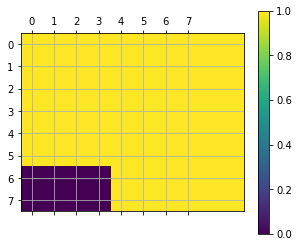

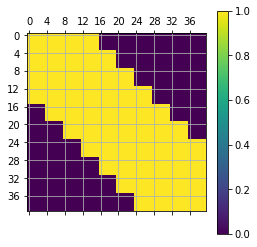

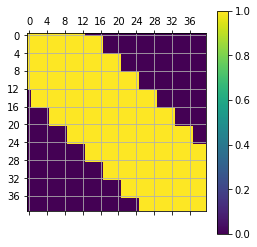

In [182]:
helpers.plot_sparsity_pattern(N_aa[10:18, 0:10], 1)
helpers.plot_sparsity_pattern(N_aa[0:40, 0:40], 4)
helpers.plot_sparsity_pattern(N_aa[-41:-1, -41:-1], 4)

21


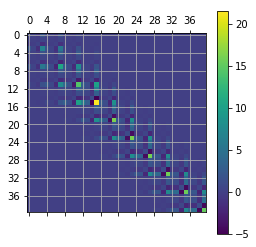

-6.189869963441599


In [183]:
N_aa = Solver.compute_attitude_LHS()
tol = 1
A = N_aa[0:40, 0:40]
B = A #np.zeros(A.shape)
# B[np.where( np.abs(A) > tol)] = 1
plt.matshow(B, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, B.shape[0], 4))
plt.yticks(np.arange(0, B.shape[0], 4))
plt.grid()
plt.show()
print(N_aa.min())

min_of_A: -5.0061271012178885
min of A:  -5.0061271012178885


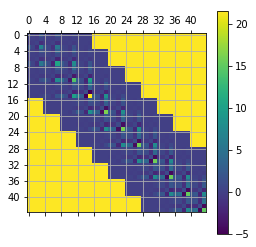

In [184]:
A = N_aa.copy()[0:44,0:44]
my_min = np.amin(A)
print('min_of_A:', my_min)
threshold = 0  #A.min()
A[np.where(A==threshold)] = A.max()
print('min of A: ',A.min())
plt.matshow(A, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, A.shape[0], 4))
plt.yticks(np.arange(0, A.shape[0], 4))
plt.grid()
plt.show()

## _And the righ hand side:_

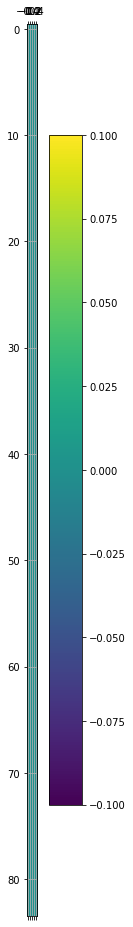

In [185]:
# Plotting h
plt.matshow(h)
plt.colorbar()
plt.grid()
plt.show()

# **Iterating:**

***** Iteration: 1 *****
21
attitude error: 0.0
Error after iteration: 0.0


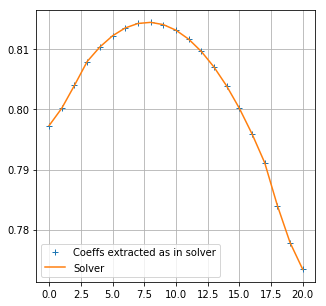

(None, <matplotlib.legend.Legend at 0x7f2fbdaa4320>, None)

In [186]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.grid(), plt.legend(), plt.show()

In [187]:
Solver.get_attitude(0.005).magnitude

0.9999999999999999

In [188]:
Solver.iterate(2)

***** Iteration: 2 *****
21
attitude error: 0.0
Error after iteration: 0.0
***** Iteration: 3 *****
21
attitude error: 0.0
Error after iteration: 0.0


In [65]:
Solver.get_attitude(0.005).magnitude

1.0